Replicated from : https://medium.com/@armandj.olivares/how-to-use-bert-for-lexical-simplification-6edbf5a4d15e

In [1]:
import re
import sys
import numpy as np
import pandas as pd
import unicodedata
from functools import lru_cache
from collections import Counter
from collections import namedtuple

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from nltk import word_tokenize
#nltk.download('brown')
from nltk import pos_tag
from nltk.corpus import brown
from nltk.corpus import stopwords

import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import tensorflow as tf
import tensorflow.keras.callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from wordfreq import zipf_frequency

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
Dataset = namedtuple('Dataset', 'name, train, test')
ModelTuple = namedtuple('Model', 'type, name, dimension, corpus, model')

In [4]:
# Pandas config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

In [9]:
MAIN_PATH_DATASET = "../../../data/cwi_shared_dataset/traindevset/english/"
MAIN_PATH_EMBEDDINGS= '../../../data/glove.6B/'

In [10]:
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

In [11]:
def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

In [12]:
datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

In [13]:
datasets[0].train.head()

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob
0,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",0,8,Normally,10,10,0,1,1,0.05
1,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",28,34,passed,10,10,0,1,1,0.05
2,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",15,19,land,10,10,0,0,0,0.00
3,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,49,future,10,10,1,0,1,0.05
4,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,61,future generations,10,10,1,2,1,0.15


In [14]:
# load embedding model
glove_models = []

glove_defs = [ ModelTuple('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]
              
for model in glove_defs:
    glove_file = MAIN_PATH_EMBEDDINGS + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(ModelTuple(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

C:\Users\Antonio\AppData\Local\Temp/ipykernel_35864/1946840910.py:9: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.KeyedVectors object at 0x0000020E200D2520>)]


In [15]:
wordlist_lowercased = set(i.lower() for i in brown.words())
print (len(wordlist_lowercased))

49815


In [16]:
datasets.append(Dataset('train_all_test_wiki', 
        datasets[0].train.append(datasets[1].train).append(datasets[2].train), datasets[0].test))

In [17]:
# Append train and test set
dataset_sel = datasets[3]
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(list(set(dataset_sel.train.sentence.values.tolist())))

test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(list(set(dataset_sel.test.sentence.values.tolist())))

dataset = dataset_sel.train.append(dataset_sel.test)
dataset['sent_id'] = dataset.groupby('sentence').ngroup()
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(list(set(dataset.sentence.values.tolist())))

print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))

# Rows train : 27299
# Rows test : 694
# Rows dataset : 27993
# Sents train : 1988
# Sents test : 53
# Sents dataset : 2041


In [18]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']] + list(wordlist_lowercased)
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    print('# embeding model  : {}'.format(len(embedding_model)))   
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    missing_embed_words = []
    i_ = 0
    for word, index in word2index.items():
        if word in embedding_model.key_to_index:
            embedding = embedding_model[word]
        else:
             i_ +=1
             missing_embed_words.append(word)
             continue
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    print("i: ", i_ )
    return word2index, index2word, embedding_matrix

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['target'], 
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0], 
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [19]:
sentences = forward_transformation(dataset)
train_sentences = sentences[:train_num_sents]
test_sentences = sentences[train_num_sents:]
words, start_end, binary, prob = split_sentence_seqs(sentences)

In [20]:
embedding_model = glove_models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 96437
# Vocab : 52455
# embeding model  : 400000
# Words missing embedding : 9834
Embedding shape : (52455, 300)
i:  9834


In [21]:

words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))


words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]

Max length sentence : 103


In [22]:
words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]


Max length sentence : 103


In [23]:
# (1) Training set
train_words_padded = words_padded[:train_num_sents]
train_binary_padded = binary_padded[:train_num_sents]
train_binary_padded_categorical = binary_padded_categorical[:train_num_sents]
train_prob_padded = prob_padded[:train_num_sents]
train_start_end = start_end[:train_num_sents]

# (2) Test set
test_words_padded = words_padded[train_num_sents:]
test_binary_padded = binary_padded[train_num_sents:]
test_binary_padded_categorical = binary_padded_categorical[train_num_sents:]
test_prob_padded = prob_padded[train_num_sents:]
test_start_end = start_end[train_num_sents:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 1988
Test set length : 53


In [45]:
class Metrics(tensorflow.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.f1_scores = []
        self.validation_data = validation_data
        
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print("\nF1 Score:")
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        self.f1_scores.append(self.f1s)
        return

In [46]:
train_words_padded.shape, np.array(train_binary_padded_categorical).shape

((1988, 103), (1988, 103, 2))

In [47]:
embedding.shape, sent_max_length

((52455, 300), 103)

In [48]:
vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm) 

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 103)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 103, 300)          15736500  
                                                                 
 dropout_1 (Dropout)         (None, 103, 300)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 103, 300)         541200    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 103, 2)           602       
 tributed)                                                       
                                                                 
Total params: 16,278,302
Trainable params: 16,278,302
Non-t

In [49]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10, 
                    epochs=3, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)), 
                    verbose=1, callbacks=[metrics])

Epoch 1/3
199/199 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9691
F1 Score:
0.05660377358490566
199/199 [==============================] - 79s 379ms/step - loss: 0.0868 - accuracy: 0.9691 - val_loss: 0.0470 - val_accuracy: 0.9780
Epoch 2/3
199/199 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9830
F1 Score:
0.05660377358490566
199/199 [==============================] - 76s 380ms/step - loss: 0.0400 - accuracy: 0.9830 - val_loss: 0.0437 - val_accuracy: 0.9808
Epoch 3/3
199/199 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9873
F1 Score:
0.05660377358490566
199/199 [==============================] - 78s 391ms/step - loss: 0.0301 - accuracy: 0.9873 - val_loss: 0.0462 - val_accuracy: 0.9808


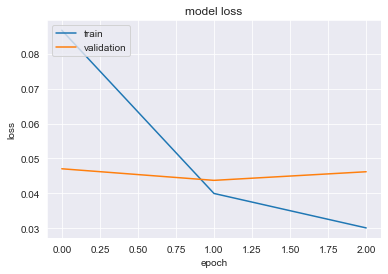

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

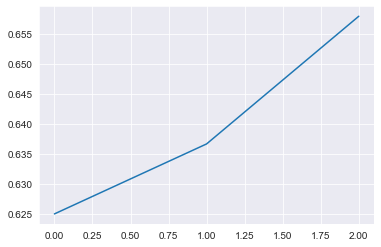

In [51]:
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

In [52]:
path_dir = '../../../models/lexical/bertls/model_CWI_full.h5'


In [53]:
model.save(path_dir)  # creates a HDF5 file 'model_CWI_full.h5'

In [54]:
model_cwi = load_model(path_dir)

In [55]:
model_cwi

In [56]:
stop_words_ = set(stopwords.words('english'))
def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', 
                '', word, flags=re.MULTILINE)
  word = re.sub('[\W]', ' ', word)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()

In [57]:
def process_input(input_text):
  input_text = cleaner(input_text)
  clean_text = []
  index_list =[]
  input_token = []
  index_list_zipf = []
  for i, word in enumerate(input_text.split()):
    if word in word2index:
      clean_text.append(word)
      input_token.append(word2index[word])
    else:
      index_list.append(i)
  input_padded = pad_sequences(maxlen=sent_max_length, sequences=[input_token], padding="post", value=0)
  return input_padded, index_list, len(clean_text)

In [58]:
def complete_missing_word(pred_binary, index_list, len_list):
  list_cwi_predictions = list(pred_binary[0][:len_list])
  for i in index_list:
    list_cwi_predictions.insert(i, 0)
  return list_cwi_predictions

In [59]:
bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertForMaskedLM.from_pretrained(bert_model)
model.eval()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementw

In [60]:
def get_bert_candidates(input_text, list_cwi_predictions, numb_predictions_displayed = 10):
  list_candidates_bert = []
  for word,pred  in zip(input_text.split(), list_cwi_predictions):
    if (pred and (pos_tag([word])[0][1] in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD' ]))  or (zipf_frequency(word, 'en')) <3.1:
      replace_word_mask = input_text.replace(word, '[MASK]')
      text = f'[CLS]{replace_word_mask} [SEP] {input_text} [SEP] '
      tokenized_text = tokenizer.tokenize(text)
      masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [0]*len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])
      # Predict all tokens
      with torch.no_grad():
          outputs = model(tokens_tensor, token_type_ids=segments_tensors)
          predictions = outputs[0][0][masked_index]
      predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
      predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
      list_candidates_bert.append((word, predicted_tokens))
  return list_candidates_bert

In [61]:
list_texts = [ 
 'The Risk That Students Could Arrive at School With the Coronavirus As schools grapple with how to reopen, new estimates show that large parts of the country would probably see infected students if classrooms opened now.',
 'How a photograph of a young man cradling his dying friend sent me on a journey across India.',
 'Pro-democracy parties, which had hoped to ride widespread discontent to big gains, saw the yearlong delay as an attempt to thwart them.',
 'Night after night, calm gave way to chaos. See what happened between the protesters and the federal agents.',
 'Contact Tracing Is Failing in Many States. Here is Why. Inadequate testing and protracted delays in producing results have crippled tracking and hampered efforts to contain major outbreaks.',
 'After an initial decrease in the youth detention population, the rate of release has slowed, and the gap between white youth and Black youth has grown.'
 'A laboratory experiment hints at some of the ways the virus might elude antibody treatments. Combining therapies could help, experts said.',
 'Though I may not be here with you, I urge you to answer the highest calling of your heart and stand up for what you truly believe.',
 'The research does not prove that infected children are contagious, but it should influence the debate about reopening schools, some experts said.',
 'Dropping antibody counts are not a sign that our immune system is failing against the coronavirus, nor an omen that we can not develop a viable vaccine.',
 'The Senate majority leader has said he will not approve a stimulus package without a “liability shield,” but top White House officials say they do not see it as essential.',
 'Campaign efforts to refocus come as the president continues to push divisive messages that have frustrated his own party.'
] 

In [62]:
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text) 
  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

Original text:  The Risk That Students Could Arrive at School With the Coronavirus As schools grapple with how to reopen, new estimates show that large parts of the country would probably see infected students if classrooms opened now.
Simplified text: The Risk That Students Could Arrive at School With the Coronavirus As schools deal with how to open new numbers show that large parts of the country would probably see infected students if they opened now. 

Original text:  How a photograph of a young man cradling his dying friend sent me on a journey across India.
Simplified text: How a shot of a young man and his dying friend sent me on a journey across India. 

Original text:  Pro-democracy parties, which had hoped to ride widespread discontent to big gains, saw the yearlong delay as an attempt to thwart them.
Simplified text: Pro-democracy parties, which had hoped to ride widespread opposition to big gains, see the year delay as an attempt to stop while 

Original text:  Night after 